Classification Report:

              precision    recall  f1-score   support

   lower fat       0.41      0.51      0.46        86
  higher fat       0.51      0.41      0.45       106

    accuracy                           0.45       192
   macro avg       0.46      0.46      0.45       192
weighted avg       0.46      0.45      0.45       192



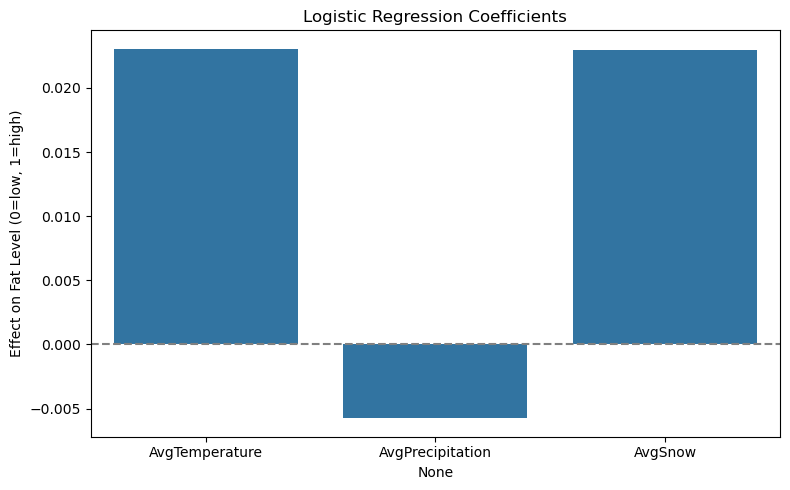

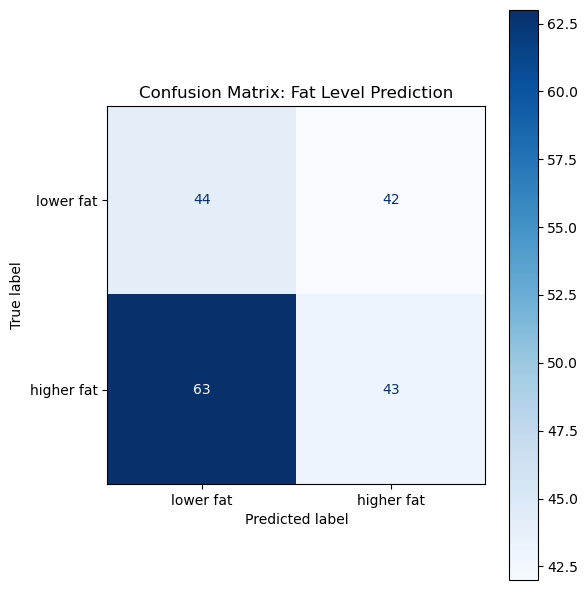

In [22]:
#------------------------------------------
# CANADIAN CHEESE DATA ANALYSES ASSESSMENTS 
# -----------------------------------------

#--------------------------------------------
# Assessments Definition
# -------------------------------------------
# The Objective of this Project is to find if there are any inferences between weather in a Canadian Province and Cheese Produced.
# In this case, I will be specific on British Columbia
#---------------------------------------------

# This Jupyter Notebook is coded and commented by Joseph Ndepuh, and dated on 04th June 2025

# Import the relevant Jupyter library package
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

# ---------------------------
# 1. Load and Prepare Data
# ---------------------------

# Load CSV files
cheese = pd.read_csv("cheese_data.csv")
weather = pd.read_csv("canada_temperature.csv")

# Filter for British Columbia
cheese_bc = cheese[cheese['ManufacturerProvCode'] == 'BC'][['MoisturePercent', 'FatLevel']].dropna()
weather_bc = weather[weather['Prov'] == 'BC'].copy()

# Convert weather columns to numeric
weather_bc['Tm'] = pd.to_numeric(weather_bc['Tm'], errors='coerce')
weather_bc['P'] = pd.to_numeric(weather_bc['P'], errors='coerce')
weather_bc['S'] = pd.to_numeric(weather_bc['S'], errors='coerce')

# Monthly weather averages
monthly_weather = weather_bc.groupby('Month')[['Tm', 'P', 'S']].mean().reset_index()
monthly_weather.rename(columns={'Tm': 'AvgTemperature', 'P': 'AvgPrecipitation', 'S': 'AvgSnow'}, inplace=True)

# ---------------------------
# 2. Cross Merge Data
# ---------------------------
# Create a cross join so each cheese sample is paired with monthly weather
cheese_bc['key'] = 1
monthly_weather['key'] = 1
merged = pd.merge(cheese_bc, monthly_weather, on='key').drop(columns='key')

# ---------------------------
# 3. Focus on Binary Fat Level
# ---------------------------
# Only keep 'lower fat' and 'higher fat'
binary_data = merged[merged['FatLevel'].isin(['lower fat', 'higher fat'])].copy()
binary_data['FatLevelEncoded'] = binary_data['FatLevel'].map({'lower fat': 0, 'higher fat': 1})

# ---------------------------
# 4. Balance the Dataset
# ---------------------------
# Resample to balance class sizes
lower_fat = binary_data[binary_data['FatLevelEncoded'] == 0]
higher_fat = binary_data[binary_data['FatLevelEncoded'] == 1]
max_count = max(len(lower_fat), len(higher_fat))

lower_fat_up = resample(lower_fat, replace=True, n_samples=max_count, random_state=42)
higher_fat_up = resample(higher_fat, replace=True, n_samples=max_count, random_state=42)
balanced_data = pd.concat([lower_fat_up, higher_fat_up])

# ---------------------------
# 5. Train Logistic Regression Model
# ---------------------------
X = balanced_data[['AvgTemperature', 'AvgPrecipitation', 'AvgSnow']]
y = balanced_data['FatLevelEncoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ---------------------------
# 6. Evaluation and Data Visualization
# ---------------------------

# Print classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['lower fat', 'higher fat']))

# --- Plot Coefficients ---
coefs = model.coef_[0]
features = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=features, y=coefs)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Logistic Regression Coefficients')
plt.ylabel('Effect on Fat Level (0=low, 1=high)')
plt.tight_layout()
plt.show()

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['lower fat', 'higher fat'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Fat Level Prediction")
plt.tight_layout()
plt.show()

# --- Conclusion ---
# There is no strong statistical meaningful inference between the weather conditions and fat level of cheese produced based on
# data given because of the low predictive power from the weather variables and lack of cheese record linkage
